In [10]:
import os
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = 50
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from dotenv import load_dotenv
from IPython.display import Markdown

In [11]:
# For specific functions in the notebook
import openai
import langchain
from langchain.prompts import PromptTemplate
from langchain.chains.qa_with_sources import load_qa_with_sources_chain
from langchain.llms import OpenAI
from langchain.embeddings import HuggingFaceInstructEmbeddings


In [12]:
# UDFs
from token_catcher import Usage
from semantic_search import SemanticSearch

In [13]:
load_dotenv()

True

In [14]:
df = pd.read_parquet("reddit_legal_cluster_test_results.parquet")

In [8]:
df.to_csv("reddit_legal_cluster_test_results.csv", index=False)

In [15]:
df['timestamp'] = pd.to_datetime(df['created_utc'], unit='s')
df['datestamp'] = df['timestamp'].dt.date

In [16]:
print(df.shape)
df.head(2)

(5000, 16)


,index,created_utc,full_link,id,body,title,text_label,flair_label,embeddings,token_count,llm_title,State,kmeans_label,topic_title,timestamp,datestamp
1078,1078,1575952538,https://www.reddit.com/r/legaladvice/comments/...,e8lsen,I applied for a job and after two interviews I...,"Failed a drug test due to amphetamines, I have...",employment,5,"[9.475638042064453e-05, 0.0005111666301983955,...",493,"""Validity of Schedule II Drug Prescription in ...",PR,8,Employment Legal Concerns and Issues,2019-12-10 04:35:38,2019-12-10
2098,2098,1577442453,https://www.reddit.com/r/legaladvice/comments/...,eg9ll2,"Hi everyone, thanks in advance for any guidanc...","Speeding ticket in Tennessee, Georgia Driver's...",driving,4,"[-0.006706413111028856, 0.020911016696181495, ...",252,"""Speeding ticket consequences for out-of-state...",KY,10,Legal Topics in Traffic Violations,2019-12-27 10:27:33,2019-12-27


In [17]:
df.topic_title.nunique()

11

In [18]:
df.topic_title.value_counts()

topic_title
Legal Topics in Rental Properties           648
Employment Legal Concerns and Issues        617
Child Custody and Related Issues            576
Legal Consequences of False Accusations     567
Rental Property and Landlord Matters        523
Compilation of Legal Topics                 461
Legal Issues in Consumer Protection         384
Legal Topics in Traffic Violations          343
Car Accident Liability and Insurance        336
COVID-19 Employment and Benefit Concerns    277
Legal Issues in Estate Administration       268
Name: count, dtype: int64

In [8]:
# Formatter to convert numbers into 'k' format
def thousands_formatter(x, pos):
    return f'{x * 1e-3}k'

def heatmap_cooccurences(df, col1, col2):
    # Create a co-occurrence matrix
    cooccurrence_matrix = pd.crosstab(df[col1], df[col2])
    
    # Generate heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(cooccurrence_matrix, annot=True, cmap='YlGnBu', fmt='g', cbar_kws={'format': FuncFormatter(thousands_formatter)})
    plt.show()

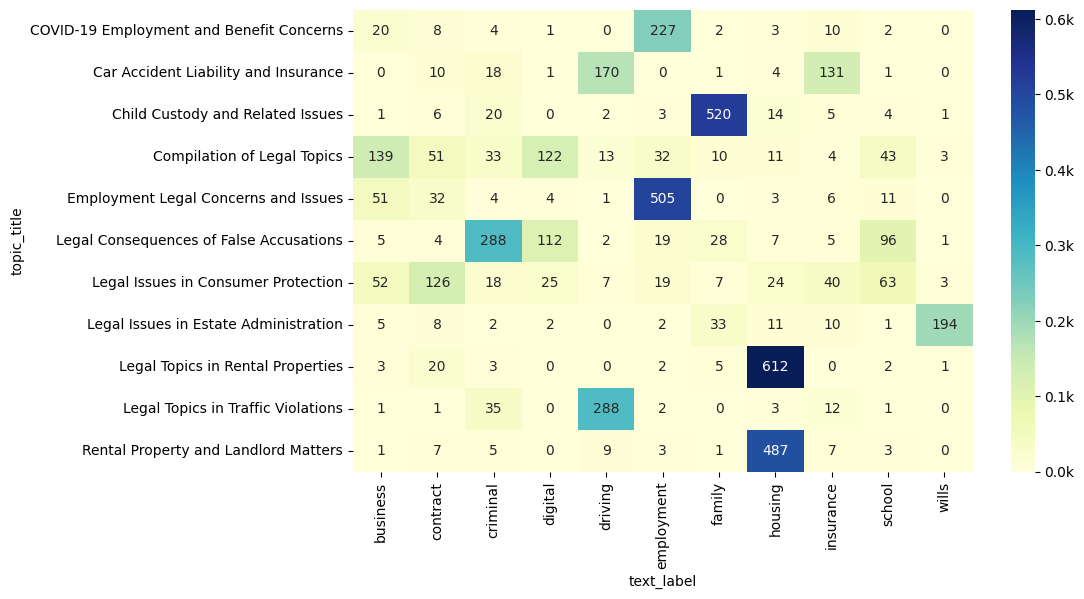

In [9]:
heatmap_cooccurences(df, "topic_title", "text_label")

In [23]:
test_query = df['body'].tail(1).tolist()[0]
print(test_query)

Hey folks;

I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial income via crowdfunding. At this point:  I have virtually no initial startup funds.

So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they 100% get paid for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.

Any advice would be appreciated. Thanks!


In [24]:
search_engine = SemanticSearch(df)

In [25]:
top_n = 5
filter_criteria = None
use_cosine_similarity = True

In [26]:
test_res = search_engine.query_similar_documents(test_query, top_n, filter_criteria, use_cosine_similarity)

In [27]:
test_res.head(2)

,index,created_utc,full_link,id,body,title,text_label,flair_label,embeddings,token_count,llm_title,State,kmeans_label,topic_title,timestamp,datestamp,sim_score
8627,8627,1589322350,https://www.reddit.com/r/legaladvice/comments/...,gilww3,Hey folks;\n\nI'm currently designing a video ...,[OH] Advice on safe contracts for freelancers/...,contract,1,"[0.010599094232140971, -0.01940659953784975, -...",191,"""Protecting Intellectual Property and Ensuring...",OR,6,Compilation of Legal Topics,2020-05-12 22:25:50,2020-05-12,0.967293
8236,8236,1421900108,https://www.reddit.com/r/legaladvice/comments/...,2t9664,"So, recently I've been getting a bit stale at ...",Independent Contractor: Things to Watch Out Fo...,contract,1,"[0.004767628551109627, -0.030685936228185846, ...",223,"""Legal considerations for becoming an independ...",CT,6,Compilation of Legal Topics,2015-01-22 04:15:08,2015-01-22,0.854329


In [28]:
def get_top_ten_docs(query: str, df: pd.DataFrame):
    search_engine = SemanticSearch(df)
    res = search_engine.query_similar_documents(query, top_n=10, filter_criteria=None)
    
    docs = []
    for i, row in res.iterrows():
        doc = langchain.docstore.document.Document(
            page_content=row['body'],
            metadata={"source": row['full_link']},
            lookup_index=i,
        )
        docs.append(doc)
    return docs    

In [129]:
docs = get_top_ten_docs(test_query, df)

In [130]:
print(docs[0].page_content)

Hey folks;

I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial income via crowdfunding. At this point:  I have virtually no initial startup funds.

So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they 100% get paid for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.

Any advice would be appreciated. Thanks!


In [131]:
docs.pop(0)

Document(page_content='Hey folks;\n\nI\'m currently designing a video game that I know will turn a good profit. The business machinations, marketing, and project management are my forte but I lack in the programming and 3D modelling department. So, I\'ll need to hire independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial income via crowdfunding. At this point:  I have virtually no initial startup funds.\n\nSo, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they 100% get paid for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder take the game concept and/or 3D models and running away with it. I\'m located in Ohio but will likely need to hire contractors from different states, maybe even different countries.\n\nAny advice would be appreciated. Thanks!', metadata={'source': 'https://www.reddit.com/r/legaladv

In [132]:
print(docs[0].page_content)

So, recently I've been getting a bit stale at my old job, working in software development at a University and was looking for something new. A group of guys are working on a startup for a software product and are ready to bring it closer to testing (beta) stage, but need some help with some software development. They saw my LinkedIn, saw my resume, and want to hire me.

Here's the kicker: they want to hire me as an independent contractor. The company is not incorporated yet, they're hoping to get into an accelerator that will help and pay for them to incorporate. They offered to pay all of my self-employment taxes as a contractor, and also formulate the agreement so I am not liable for mistakes after my contract is over in exchange for giving them the copyright to my code.

I'm supposed to be expecting a first agreement of the draft within 24 hours. What are some gotchas or other items I should watch out for based on your experiences? What legal steps can I take to avoid a potentially 

In [149]:
def get_langchain_response(docs, query, k=5):
    """
    Using LangChain mapreduce
    """
    question_prompt_template = """Use the following initial semantic search results to see if any of the texts are similar to a new query. 

    {context}
    Query: {question}
    Similar texts:"""
    QUESTION_PROMPT = PromptTemplate(
        template=question_prompt_template, input_variables=["context", "question"]
    )

    combine_prompt_template = """Using the following new text, and examples of similar past texts, perform two tasks.  
    (1) Summarize the new text.
    (2) Generate a bullet point list of similarities to past texts
    Create a final answer with references ("SOURCES")
    ALWAYS return a "SOURCES" part at the end of your answer. Return sources as a list of strings, e.g. ["source1", "source2", ...]

    TEXT: {question}
    =========
    {summaries}
    =========
    FINAL ANSWER:"""
    COMBINE_PROMPT = PromptTemplate(
        template=combine_prompt_template, input_variables=["summaries", "question"]
    )

    chain = load_qa_with_sources_chain(
        OpenAI(temperature=0.0),
        chain_type="map_reduce",
        return_intermediate_steps=True,
        question_prompt=QUESTION_PROMPT,
        combine_prompt=COMBINE_PROMPT,
    )
    chain_out = chain(
        {"input_documents": docs[:k], "question": query}, return_only_outputs=True
    )
    return chain_out

In [150]:
chain_out = get_langchain_response(docs, test_query, k=8)

In [151]:
output_text = chain_out["output_text"].split("\n\nSOURCES: ")[0].strip()

In [152]:
Markdown(f"{output_text}")

Summary: The new text is about an individual who is designing a video game and is looking for advice on how to protect their intellectual property and ensure that independent contractors/freelancers are paid for their work, especially when hiring from different states or countries.

Similarities to Past Texts:
- Legal considerations of hiring independent contractors for software development
- Best practices for protecting intellectual property when hiring freelancers
- Legal implications of hiring contractors from different states or countries
- Protecting oneself when talking to strangers
- Consulting with a lawyer or financial advisor to get more specific advice on the legal and financial implications of forming a business
- Different types of business structures and the associated legal and financial implications of each
- Resources available online that can provide advice on contracts and intellectual property protection for video game development
- Forming an LLC and protecting intellectual property

In [153]:
output_text_ = {"output_text": output_text, "sources": sources}

In [154]:
Markdown(f"### {output_text_['output_text']}\n\n")

### Summary: The new text is about an individual who is designing a video game and is looking for advice on how to protect their intellectual property and ensure that independent contractors/freelancers are paid for their work, especially when hiring from different states or countries.

Similarities to Past Texts:
- Legal considerations of hiring independent contractors for software development
- Best practices for protecting intellectual property when hiring freelancers
- Legal implications of hiring contractors from different states or countries
- Protecting oneself when talking to strangers
- Consulting with a lawyer or financial advisor to get more specific advice on the legal and financial implications of forming a business
- Different types of business structures and the associated legal and financial implications of each
- Resources available online that can provide advice on contracts and intellectual property protection for video game development
- Forming an LLC and protecting intellectual property



In [156]:
for source in output_text_["sources"]:
    try:
        title = df[df["full_link"] == source]["llm_title"].values[0]
        link = f"{source}"
        venue = df[df["full_link"] == source]["State"].values[0]
        date = df[df["full_link"] == source]["datestamp"].values[0]
        display(Markdown(f"* #### [{title}]({link}) - {venue}, {date}"))
    except:
        display(Markdown(f"Source not found: {source}"))

* #### ["Is it discrimination if a company refuses to hire me due to my prescribed medication?"](https://www.reddit.com/r/legaladvice/comments/gnpjof/nj_i_was_denied_a_job_due_to_being_prescribed/) - MI, 2020-05-21

Source not found: https://www.reddit.com/r/legaladvice/comments/52rcpe/tn_im_apparently_a_poi_at_my_new_uni

In [157]:
output_text_["sources"]

['https://www.reddit.com/r/legaladvice/comments/gnpjof/nj_i_was_denied_a_job_due_to_being_prescribed/',
 'https://www.reddit.com/r/legaladvice/comments/52rcpe/tn_im_apparently_a_poi_at_my_new_uni']

In [158]:
def return_answer_markdown(chain_out, df, query):
    """
    Parse the output_text and sources from the chain_out JSON and return a markdown string
    """
    output_text = chain_out["output_text"].split("\n\nSOURCES: ")[0].strip()
    if chain_out["output_text"].endswith("]"):
        sources = eval(chain_out["output_text"].split("SOURCES:")[1].strip())
    else:
        sources = eval(chain_out["output_text"].split("SOURCES:")[1].strip() + '"]')

    # Creating a new JSON with the extracted output_text and sources
    output_text = {"output_text": output_text, "sources": sources}

    # Printing the new JSON
    display(Markdown(f"## New Question\n\n"))

    display(Markdown(f"{query}\n\n"))

    display(Markdown(f"## Model Output:\n\n"))

    display(Markdown(f"### {output_text['output_text']}\n\n"))

    display(Markdown(f"## Sources: \n\n"))

    # markdown headings for each source
    for source in output_text["sources"]:
        try:
            title = df[df["full_link"] == source]["llm_title"].values[0]
            link = f"{source}"
            venue = df[df["full_link"] == source]["State"].values[0]
            date = df[df["full_link"] == source]["datestamp"].values[0]
            display(Markdown(f"* #### [{title}]({link}) - {venue}, {date}"))
        except:
            display(Markdown(f"Source not found: {source}"))

In [159]:
print(test_query)

Hey folks;

I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial income via crowdfunding. At this point:  I have virtually no initial startup funds.

So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they 100% get paid for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.

Any advice would be appreciated. Thanks!


In [160]:
return_answer_markdown(chain_out, df, query=test_query)

## New Question



Hey folks;

I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial income via crowdfunding. At this point:  I have virtually no initial startup funds.

So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they 100% get paid for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.

Any advice would be appreciated. Thanks!



## Model Output:



### Summary: The new text is about an individual who is designing a video game and is looking for advice on how to protect their intellectual property and ensure that independent contractors/freelancers are paid for their work, especially when hiring from different states or countries.

Similarities to Past Texts:
- Legal considerations of hiring independent contractors for software development
- Best practices for protecting intellectual property when hiring freelancers
- Legal implications of hiring contractors from different states or countries
- Protecting oneself when talking to strangers
- Consulting with a lawyer or financial advisor to get more specific advice on the legal and financial implications of forming a business
- Different types of business structures and the associated legal and financial implications of each
- Resources available online that can provide advice on contracts and intellectual property protection for video game development
- Forming an LLC and protecting intellectual property



## Sources: 



* #### ["Legal considerations for becoming an independent contractor and transferring copyright in a software development agreement"](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/) - CT, 2015-01-22

Source not found: https://www.reddit.com/r/legaladvice/comments/2xzeee/advice_on_steps_i

* Summarizer Model

In [20]:
from langchain import LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)


system_template = "You are an actuarial documentation specialist. You're helping me summarize legal questions related to insurance."
human_template = "Using the following scenario, write a concise summary that focuses on insurance and legal topics.\n\nDESCRIPTIONS:{text}\n\nSUMMARY:"

prompt = ChatPromptTemplate(
    messages=[
        SystemMessagePromptTemplate.from_template(system_template),
        HumanMessagePromptTemplate.from_template(human_template),
    ],
    input_variables=["text"],
)
    
chain = LLMChain(
    llm=ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo", max_tokens=512), prompt=prompt, verbose=False
)

In [21]:
def get_summary(input_text: str):
    output_text = chain.run(input_text)
    return output_text

In [29]:
test_summary = get_summary(test_query)

In [30]:
Markdown(f"{test_query}")

Hey folks;

I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial income via crowdfunding. At this point:  I have virtually no initial startup funds.

So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they 100% get paid for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.

Any advice would be appreciated. Thanks!

In [31]:
Markdown(f"{test_summary}")

The individual is seeking advice on the types of contracts they can use to ensure that independent contractors/freelancers are paid for their work and to protect their intellectual property in the development of a video game. They are concerned about the possibility of contractors taking the game concept or 3D models and leaving. They are located in Ohio but may hire contractors from different states or countries.

In [32]:
query = df['body'].head(1).tolist()[0]
print(query)

I applied for a job and after two interviews I was given for and agreed to an offer letter, had a start date.  The only remaining variable was a drug test, which I prepared myself for by bringing all my prescriptions with me.  

I take Adderall, my doctor prescribes me for 3 pills a day, insurance pays for only two a day so that’s what I get.  2 pills a day for 30 days.  

However, I don’t need adderall everyday, so I only take it as needed.  My psychiatrist knows this and is okay with it.  I don’t take it everyday so my prescription can last me months, depending on circumstances.  

Of course, I happen to take a drug test for a possible new job the day after taking an adderall at work.  No big deal, I have a prescription and it’s never been a big deal in the past.  

Except this time it was.  According to the doctor who administrated the test, my prescription was too old.  How old was it, I was prescribed in June and filled the prescription on July 8th, 2019.  I still have about a thi

In [33]:
def get_results(df: pd.DataFrame, query: str, limit: int = 20) -> pd.DataFrame:
    search_engine = SemanticSearch(df)
    res = search_engine.query_similar_documents(query, top_n=limit+1, filter_criteria=None)
    return res.iloc[1:] # Omits the first row as it is usually the query in this dev setting

In [34]:
df_res = get_results(df, query)

In [35]:
df_res.head(2)

,index,created_utc,full_link,id,body,title,text_label,flair_label,embeddings,token_count,llm_title,State,kmeans_label,topic_title,timestamp,datestamp,sim_score
6191,6191,1590032420,https://www.reddit.com/r/legaladvice/comments/...,gnpjof,I applied to a small private transport company...,(NJ) I was denied a job due to being prescribe...,employment,5,"[-0.014932120068105919, -0.01118895493326352, ...",235,"""Is it discrimination if a company refuses to ...",MI,8,Employment Legal Concerns and Issues,2020-05-21 03:40:20,2020-05-21,0.709400
9156,9156,1473870804,https://www.reddit.com/r/legaladvice/comments/...,52rcpe,"I'm a Freshman adult, former Texan resident an...",(TN) I'm apparently a POI at my new Uni. Shoul...,criminal,2,"[0.01599887962418506, 0.010982281649642614, 0....",546,"""Legal advice needed: Accused of selling Xanax...",MT,9,Legal Consequences of False Accusations,2016-09-14 16:33:24,2016-09-14,0.658507


In [36]:
df_res['summary'] = df_res['body'].apply(get_summary)

In [37]:
df_res['summary'].head().tolist()

["The individual applied for a job at a small private transport company and tested positive for amphetamines during the drug test. They provided a doctor's note explaining their prescription for Adderall XR 10mg for ADHD. The employer asked if they could refrain from taking their medication, to which the individual declined as it helps them function. The employer then emailed stating they were unable to hire the individual due to liability issues associated with their medications. The individual has a history of volunteering in 911 EMS without any issues while on medication. The medication does come with a warning about impairment. The individual's friends believe this is discrimination, but the individual wants to know if it qualifies as such before filing an ADA complaint.",
 'The individual is a college student who takes multiple prescribed medications for mental health. They recently tested positive for their medications during an ER visit. A friend informed them that their name is

In [198]:
df_res['len_body'] = df_res['body'].str.len()
df_res['len_summary'] = df_res['summary'].str.len()

In [199]:
df_res['compress_chars'] = df_res['len_body'] - df_res['len_summary']

<Axes: >

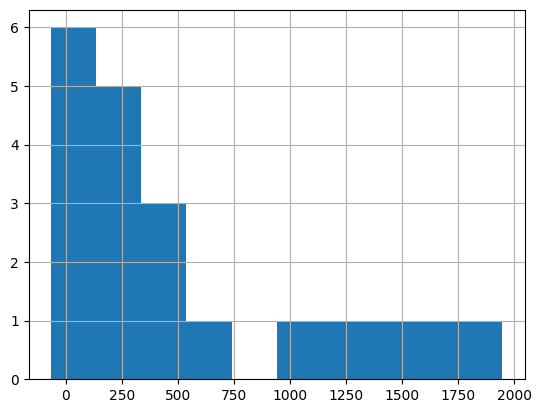

In [202]:
df_res['compress_chars'].hist()

In [38]:
from langchain.embeddings import HuggingFaceInstructEmbeddings

In [39]:
instruct_query_embeddings = HuggingFaceInstructEmbeddings(
    query_instruction="Represent the legal query for retrieving similar documents: "
)

instruct_doc_embeddings = HuggingFaceInstructEmbeddings(
    query_instruction="Represent the legal document for retrieval: "
)

c:\Users\pdoub\Desktop\python_projects\junk-drawer\.venv\lib\site-packages\InstructorEmbedding\instructor.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange


load INSTRUCTOR_Transformer
max_seq_length  512
load INSTRUCTOR_Transformer
max_seq_length  512


In [40]:
import nltk

def preprocess_text(text: str):
    text = text.lower()
    # remove stopwords from the query
    stopwords = set(nltk.corpus.stopwords.words("english"))
    # Example of adding words to the stopwords list
    stopwords.update(["please", "review"])
    text = " ".join([word for word in text.split() if word not in stopwords])
    return text

In [41]:
from sklearn.metrics.pairwise import cosine_similarity

In [42]:
df_res.head(2)

,index,created_utc,full_link,id,body,title,text_label,flair_label,embeddings,token_count,llm_title,State,kmeans_label,topic_title,timestamp,datestamp,sim_score,summary
6191,6191,1590032420,https://www.reddit.com/r/legaladvice/comments/...,gnpjof,I applied to a small private transport company...,(NJ) I was denied a job due to being prescribe...,employment,5,"[-0.014932120068105919, -0.01118895493326352, ...",235,"""Is it discrimination if a company refuses to ...",MI,8,Employment Legal Concerns and Issues,2020-05-21 03:40:20,2020-05-21,0.709400,The individual applied for a job at a small pr...
9156,9156,1473870804,https://www.reddit.com/r/legaladvice/comments/...,52rcpe,"I'm a Freshman adult, former Texan resident an...",(TN) I'm apparently a POI at my new Uni. Shoul...,criminal,2,"[0.01599887962418506, 0.010982281649642614, 0....",546,"""Legal advice needed: Accused of selling Xanax...",MT,9,Legal Consequences of False Accusations,2016-09-14 16:33:24,2016-09-14,0.658507,The individual is a college student who takes ...


In [43]:
def rerank(df: pd.DataFrame, query: str, text_col_name: str) -> pd.DataFrame:
    query_proc = preprocess_text(query)
    query_embedding = instruct_query_embeddings.embed_query(query_proc)
    query_embedding = np.array(query_embedding)
    query_embedding = np.expand_dims(query_embedding, axis=0)
    doc_embeddings = instruct_doc_embeddings.embed_documents(df[text_col_name].tolist())
    df["instruct_embeddings"] = list(doc_embeddings)
    df["similarity"] = cosine_similarity(query_embedding, doc_embeddings).flatten()
    # sort the dataframe by similarity
    df.sort_values(by="similarity", ascending=False, inplace=True)
    return df
    

In [44]:
rerank_res_df = rerank(df_res, query, 'summary')

In [45]:
def create_context_chatgpt(question, df, k=5):
    """
    Create a context for a question by using the most similar text from the dataframe
    """

    returns = []
    count = 1
    # Add the text to the context until the context is too long
    for i, row in df[:k].iterrows():

        # Else add it to the text that is being returned
        returns.append(
            "["
            + str(count)
            + "] "
            + row["summary"]
            + "\nURL: "
            + row["full_link"]
        )
        count += 1
    # Return the context
    return "\n\n".join(returns)

In [46]:
def answer_question_chatgpt(
    df,
    question=query,
    k=5,
    instructions="""Instructions: Using the provided search results, write a detailed comarative analysis for a new query. Make sure to cite results using [[number](URL)] notation after the reference. End your answer with a summary. \nNew Query:""",
    max_len=3000,
    debug=False,
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context_chatgpt(question, df, k=k)

    try:
        # Create a completions using the question and context
        # prompt = f'''{context} \n\n Instructions: Using the provided literature with sources, write a comprehensive reply to the given query. Make sure to cite results using [[number](URL)] notation after the reference. If the provided search results refer to multiple subjects with the same name, write separate answers for each subject. You can skip a citation which you dont find relevant to the query. \nQuery:{question}\nAnswer:'''
        prompt = f"""{context} \n\n{instructions} {question}\nAnswer:"""
        return prompt
    except Exception as e:
        print(e)
        return ""

In [47]:
# create prompt with the top 8 results
prompt = answer_question_chatgpt(rerank_res_df, 
                                 query, 
                                 k=8, 
)

In [48]:
print(prompt)

[1] The individual applied for a job at a small private transport company and tested positive for amphetamines during the drug test. They provided a doctor's note explaining their prescription for Adderall XR 10mg for ADHD. The employer asked if they could refrain from taking their medication, to which the individual declined as it helps them function. The employer then emailed stating they were unable to hire the individual due to liability issues associated with their medications. The individual has a history of volunteering in 911 EMS without any issues while on medication. The medication does come with a warning about impairment. The individual's friends believe this is discrimination, but the individual wants to know if it qualifies as such before filing an ADA complaint.
URL: https://www.reddit.com/r/legaladvice/comments/gnpjof/nj_i_was_denied_a_job_due_to_being_prescribed/

[2] The individual is seeking help with employer issues related to a drug test. They claim that they were 

In [49]:
def print_papers(df, k=8):
    count = 1
    for i in range(k):
        # add index
        title = df.iloc[i]["llm_title"]
        link = f"{df.iloc[i]['full_link']}"
        venue = df.iloc[i]["State"]
        date = df.iloc[i]["datestamp"]
        display(Markdown(f"#### {[count]} [{title}]({link}) - {venue}, {date}"))
        count+=1

In [50]:
def generate_answer(prompt):
    """Generates an answer using ChatGPT."""
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {
                "role": "system",
                "content": "You are helpful legal research assistant. Analyze the current legal question, and compare it to past cases. Using only the provided context, offer insights into how the researcher can use the past questions to address the new outstanding issue.",
            },
            {"role": "user", "content": prompt},
        ],
    )
    return response.choices[0].message.content

In [51]:
response = generate_answer(prompt)

In [52]:
Markdown(f"## ChatGPT Response: \n\n {response}")

## ChatGPT Response: 

 To address the new query, we can look at the previous cases that involve drug testing and prescription medications. Specifically, we can refer to cases [1], [3], [5], and [8], as they involve similar situations or legal issues related to drug testing and prescription medications. 

In case [1], an individual applied for a job and tested positive for amphetamines during the drug test due to their prescription for Adderall XR 10mg for ADHD. The employer refused to hire the individual, citing liability issues. This case demonstrates the potential for discrimination based on a prescription medication. 

Case [3] involves an individual who works in aircraft maintenance and undergoes random drug testing. The company schedules the tests after the individual's shift, causing conflicts with necessary doctor appointments. The individual is concerned about potential termination if they were to miss a drug test. This case highlights the importance of balancing personal life and job requirements when it comes to drug testing.

In case [5], an individual in Pennsylvania is concerned about drug testing for employment, particularly in relation to their medical marijuana use. They seek clarification on the employer's grounds for dismissal in this situation. This case addresses the legal implications of medical marijuana use in the context of employment and drug testing.

Lastly, case [8] involves a New York State medical marijuana patient facing discrimination from a hospital for disclosing their medical marijuana card during the pre-employment process. The hospital refuses to hire them based on their status as a medical marijuana patient. This case explores the legality of discrimination against medical marijuana patients in employment.

Based on these past cases, the researcher could suggest the following insights to address the new query:

1. Review relevant Texas state laws: While the previous cases primarily involve federal regulations, it would be helpful for the researcher to analyze Texas-state-specific laws regarding drug testing and prescription medication. This could include looking into state-specific discrimination laws and regulations relating to controlled substances.

2. Evaluate the employer's drug testing policy: It is important to understand the employer's drug testing policy and whether it aligns with applicable laws and regulations. If the policy is not properly communicated, informed consent may be at issue, as seen in case [2].

3. Consider ADA protections: In cases where the individual has a disability and requires medication, such as in case [1], the researcher could explore whether the employer's actions may violate the Americans with Disabilities Act (ADA). The ADA prohibits discrimination against individuals with disabilities, including those who are prescribed medication for their condition.

4. Consult legal counsel: Given the complexity and potential implications of this situation, it may be advisable for the individual to consult an employment attorney familiar with drug testing and employment law in Texas.

In summary, by referencing past cases involving drug testing and prescription medications, the researcher can gain insights into how Texas state laws, employer policies, ADA protections, and other relevant factors may apply to the new query. Legal counsel can provide specific guidance and advice based on the individual's unique circumstances.

In [53]:
print_papers(rerank_res_df, k=8)

#### [1] ["Is it discrimination if a company refuses to hire me due to my prescribed medication?"](https://www.reddit.com/r/legaladvice/comments/gnpjof/nj_i_was_denied_a_job_due_to_being_prescribed/) - MI, 2020-05-21

#### [2] ["Unfair treatment at work due to unclear drug testing policy: Seeking legal guidance in Cleveland, Ohio"](https://www.reddit.com/r/legaladvice/comments/ebxmgq/am_i_being_treated_fairly_and_is_there_anything_i/) - OH, 2019-12-17

#### [3] ["Can my employer terminate me for missing a random drug test due to conflicting doctor's appointments?"](https://www.reddit.com/r/legaladvice/comments/ec1oz9/us_dot_drug_testing_question/) - CA, 2019-12-17

#### [4] ["Legal rights regarding medication refusal and custody disputes in the USA"](https://www.reddit.com/r/legaladvice/comments/7pgdhs/what_happens_when_unmarried_parents_disagree_on/) - NM, 2018-01-10

#### [5] ["Medical Marijuana and Employment: Can failing a drug test lead to termination or fines?"](https://www.reddit.com/r/legaladvice/comments/gnrqby/if_i_have_a_medical_marijuana_card_can_i_be_fired/) - DE, 2020-05-21

#### [6] ["Legal implications of using CBD/hemp while working a federal job and potential consequences of failing a drug test"](https://www.reddit.com/r/legaladvice/comments/ebebz1/would_quitting_over_a_drug_test_be_worse_than/) - HI, 2019-12-16

#### [7] ["Legality of random drug testing in California for non-dangerous job roles and consequences of refusal"](https://www.reddit.com/r/legaladvice/comments/gsm10j/question_about_random_drug_testing/) - CT, 2020-05-29

#### [8] ["Can a hospital refuse to hire a medical marijuana patient based on their status?"](https://www.reddit.com/r/legaladvice/comments/gr4q8s/is_it_legal_in_new_york_to_discriminate_against/) - MI, 2020-05-26

In [303]:
import pandas as pd
import os

def generate_html_pages(df, text_column_name, folder="html_files"):
    # Create the folder if it doesn't exist
    os.makedirs(folder, exist_ok=True)

    # URL list to store the generated URLs
    urls = []

    # Loop through the DataFrame and create HTML files for each text
    for idx, row in df.iterrows():
        file_name = f'text_{idx}.html'
        file_path = os.path.join(folder, file_name)
        with open(file_path, 'w') as file:
            html_content = f"""
            <!doctype html>
            <html>
                <head><title>Text Page {idx}</title></head>
                <body><h1>{row[text_column_name]}</h1></body>
            </html>
            """
            file.write(html_content)
        
        # Assuming you'll serve files locally or provide the correct base URL
        urls.append(f'file:///{os.path.abspath(file_path)}')

    # Add URLs to the DataFrame
    df['urls'] = urls

    return df


In [304]:
test = generate_html_pages(rerank_res_df, "body", folder="html_files")

In [305]:
test['urls'].tolist()

['file:///c:\\Users\\pdoub\\Desktop\\python_projects\\junk-drawer\\src_index\\html_files\\text_6191.html',
 'file:///c:\\Users\\pdoub\\Desktop\\python_projects\\junk-drawer\\src_index\\html_files\\text_3892.html',
 'file:///c:\\Users\\pdoub\\Desktop\\python_projects\\junk-drawer\\src_index\\html_files\\text_6247.html',
 'file:///c:\\Users\\pdoub\\Desktop\\python_projects\\junk-drawer\\src_index\\html_files\\text_3842.html',
 'file:///c:\\Users\\pdoub\\Desktop\\python_projects\\junk-drawer\\src_index\\html_files\\text_7381.html',
 'file:///c:\\Users\\pdoub\\Desktop\\python_projects\\junk-drawer\\src_index\\html_files\\text_3689.html',
 'file:///c:\\Users\\pdoub\\Desktop\\python_projects\\junk-drawer\\src_index\\html_files\\text_3739.html',
 'file:///c:\\Users\\pdoub\\Desktop\\python_projects\\junk-drawer\\src_index\\html_files\\text_8075.html',
 'file:///c:\\Users\\pdoub\\Desktop\\python_projects\\junk-drawer\\src_index\\html_files\\text_1164.html',
 'file:///c:\\Users\\pdoub\\Desktop\\

In [56]:
from html import escape

# Function to create a clean and minimalistic HTML content with spacing and line borders
def create_clean_html_content(row):
    # Creating a clean HTML structure with added spacing and line borders
    html_content = f"""
    <html>
    <head>
        <title>{escape(row['title'])}</title>
        <style>
            body {{
                font-family: Arial, sans-serif;
                background-color: #f4f4f4;
                margin: 40px;
            }}
            .card {{
                background-color: #ffffff;
                padding: 20px;
                border-radius: 10px;
                box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
                max-width: 800px;
                margin: auto;
            }}
            .highlight {{
                font-weight: bold;
                color: #ff9900;
            }}
            h1 {{
                color: #333333;
            }}
            .section {{
                margin-bottom: 20px;
                padding-bottom: 10px;
                border-bottom: 1px solid #eeeeee;
            }}
            p {{
                line-height: 1.6;
                margin: 0;
            }}
            a {{
                color: #0066cc;
                text-decoration: none;
            }}
        </style>
    </head>
    <body>
        <div class="card">
            <h1>{escape(row['title'])}</h1>
            <div class="section">
                <p><span class="highlight">LLM Title:</span> {escape(row['llm_title'])}</p>
            </div>
            <div class="section">
                <p><span class="highlight">Topic Title:</span> {escape(row['topic_title'])}</p>
            </div>
            <div class="section">
                <p><span class="highlight">Body:</span> {escape(row['body'])}</p>
            </div>
            <div class="section">
                <p>Text Label: {escape(row['text_label'])}</p>
                <p>Timestamp: {row['timestamp']}</p>
                <p><a href="{row['full_link']}">Full Link</a></p>
            </div>
        </div>
    </body>
    </html>
    """
    return html_content


In [58]:
random_row = rerank_res_df.sample(1)

# Generating clean HTML content for the selected random row
clean_html_content = create_clean_html_content(random_row)

# Writing the clean HTML content to a file
clean_html_file_path = "../data/random_row_display_clean.html"
with open(clean_html_file_path, 'w', encoding='utf-8') as file:
    file.write(clean_html_content)

clean_html_file_path

'../data/random_row_display_clean.html'

In [59]:
# Function to generate HTML files for each row and add URLs to the DataFrame
def generate_html_files(df):
    # List to store the URLs
    urls = []
    
    # Iterate through the DataFrame
    for index, row in df.iterrows():
        # Generate HTML content for the row
        html_content = create_clean_html_content(row)
        
        # Define the file path for the HTML file
        file_path = f"../data/html_files/row_{index}.html"
        
        # Write the HTML content to the file
        with open(file_path, 'w', encoding='utf-8') as file:
            file.write(html_content)
        
        # Append the file path to the URLs list
        urls.append(file_path)
    
    # Add the URLs as a new column to the DataFrame
    df['html_url'] = urls
    
    return df


In [60]:
# Create a directory to store the HTML files
import os
os.makedirs("./data/html_files", exist_ok=True)

# Apply the function to generate HTML files and update the DataFrame
updated_df = generate_html_files(rerank_res_df.copy())

# Displaying the first few rows of the updated DataFrame
updated_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../data/html_files/row_6191.html'

In [306]:
import os
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import faiss
import nltk
from typing import List, Tuple, Dict
from langchain.embeddings import OpenAIEmbeddings


class SemanticSearch:
    def __init__(self, df: pd.DataFrame, embedding_col_name: str = "embeddings"):
        self.df = df
        self.embedding_col_name = embedding_col_name
        load_dotenv()
        self.embedding_model = OpenAIEmbeddings()


    @staticmethod
    def preprocess_text(text: str):
        text = text.lower()
        # remove stopwords from the query
        stopwords = set(nltk.corpus.stopwords.words("english"))
        # Example of adding words to the stopwords list
        stopwords.update(["please", "review"])
        text = " ".join([word for word in text.split() if word not in stopwords])
        return text

    
    def encode_string(self, text: str) -> np.ndarray:
        # Preprocess the text
        preprocessed_text = self.preprocess_text(text)
        # Encode the text
        embedding = self.embedding_model.embed_query(preprocessed_text)
        return np.array(embedding)
    
    
    @staticmethod
    def normalize_embeddings(embeddings: np.ndarray) -> np.ndarray:
        if len(embeddings.shape) == 1:
            embeddings = np.expand_dims(embeddings, axis=0)
        if embeddings.shape[0] == 1:
            embeddings = np.transpose(embeddings)
        norm = np.linalg.norm(embeddings, axis=1, keepdims=True)
        normalized_embeddings = embeddings / norm
        return normalized_embeddings
    
    
    def check_and_normalize_embeddings(self, embeddings: np.ndarray) -> np.ndarray:
        # Calculate the L2 norm for each embedding
        norms = np.linalg.norm(embeddings, axis=1)

        # Check if the norms are close to 1 (with a small tolerance)
        if not np.allclose(norms, 1, atol=1e-6):
            print("Embeddings are not normalized, normalizing now...")
            embeddings = self.normalize_embeddings(embeddings)

        return embeddings
    
    
    def build_faiss_index(self, embeddings: np.ndarray, use_cosine_similarity: bool = False) -> faiss.Index:
        if use_cosine_similarity:
            # Check and normalize the embeddings if needed
            embeddings = self.check_and_normalize_embeddings(embeddings)
            index = faiss.IndexFlatIP(embeddings.shape[1])
        else:
            index = faiss.IndexFlatL2(embeddings.shape[1])

        index.add(embeddings.astype('float32'))
        return index

       
    def search_faiss_index(self, index: faiss.Index, 
                            embedding: np.ndarray,
                            top_n: int,
                            use_cosine_similarity: bool) -> Tuple[List[int], np.ndarray]:
        
        distances, indices = index.search(embedding.reshape(1, -1).astype('float32'), top_n)
        
        if use_cosine_similarity:
            similarity_scores = distances.flatten()
        else:
            similarity_scores = 1 - distances.flatten()
        
        return indices.flatten(), similarity_scores


    @staticmethod
    def filter_results(df: pd.DataFrame, indices: List[int], filter_criteria: dict) -> pd.DataFrame:
        filtered_df = df.iloc[indices]
        for key, value in filter_criteria.items():
            filtered_df = filtered_df[filtered_df[key] == value]
        return filtered_df
    
    
    def query_similar_documents(self, text: str, top_n: int, filter_criteria: dict, use_cosine_similarity: bool = False) -> pd.DataFrame:
        query_embedding = self.encode_string(text)

        if filter_criteria is not None:
            filtered_df = self.df.copy()
            for key, value in filter_criteria.items():
                filtered_df = filtered_df[filtered_df[key] == value]
        else:
            filtered_df = self.df.copy()
            
        filtered_embeddings = np.vstack(filtered_df[self.embedding_col_name].values)

        index_ = self.build_faiss_index(filtered_embeddings, use_cosine_similarity)
        indices, sim_scores = self.search_faiss_index(index_, query_embedding, top_n, use_cosine_similarity)
        results_df = filtered_df.iloc[indices].copy()
        # Add 'similarity scores' to the DataFrame
        results_df['sim_score'] = sim_scores
        
        return results_df